# 2017 Leaf metabolomics analysis

This notebooke contains the analysis of the leaf metabolomics data for the first year of Aim 1 of the NSF/PGRP project "Adapting Perennial Crops for Climate Change: Graft Transmissible Effects of Rootstocks on Grapevine Shoots" (1546869). The manuscript(s) associated with the data can be found in the README of this GitHIb repository.

This code is provided for reproducability and as a backbone for future metabolomics analysis.

Questions about this code and project can be directed to Zachary N. Harris or Allison J. Miller.

In this notebook, I am going to do a rough, high level overview analysis of the data provided to me by Misha. The initial excel file (Leaf.2018and2018,positive.RP.VandHXCMSMultiClass-1.xlsx) is sort of messy, so I made it into two sepearate, R-workable files. The first is a file called featureName_map.csv which maps a unique integer value to each of the feature's metadata. The second is called 2017_leafMetabolomics_sigFeatures_MK.csv which is a sample by sample analysis of each metabolite labeled by the unique integer value. The data frames are printed in reduced view below. 

Here, I am going to do all analysis similar to the leaf shape data whereby I collapse the ~660 dimensional metabolite space into a ~20 dimensional PC space. On these 20 PCs, I will fit linear models to determine the effects of the experimental design. I am pretty sure I am going to need the rest of the data though because the data given make no sense. For example, I would expect all q-values to be higher than p-values, I have no idea what the test was to constuct the p-value, and I see no real basis for doing stats before AND AFTER the PCA. 

In [1]:
library(ggplot2)
library(tidyverse)
library(anomalize)
library(car)
library(rebus)
library(viridis)
library(emmeans)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
══ Use anomalize to improve your Forecasts by 50%! ═════════════════════════════
Business Science offers a 1-hour course - Lab #18: Time Series Anomaly Detection!
</> Learn more at: https://university.business-science.io/p/learning-labs-pro </>
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘rebus’

The following object is masked from ‘package:stringr’:

    regex

The following object is masked from ‘package:ggplot2’:

    alpha

Loading required package: viridis

## Define Color Palettes and Load Data

In [2]:
rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
p_palette <- c('purple1', 'darkorchid4')
i_palette <- c('grey', 'lightblue', 'darkblue')
t_palette <- c('darkgreen', 'mediumpurple4')
b_palette <- c('#ffd4a3', '#ffaa5e', '#d08159')
row_palette <- viridis(9)

In [3]:
featureName_map <- read.csv('featueName_map.csv')
data <- read.csv('2017_leafMetabolomics_sigFeatures_MK.csv')

In [4]:
head(featureName_map)
head(data)

featureidx,name,mzmed,mz.simple,mzmin,mzmax,rtmed,RT.simple,rtmin,rtmax,npeaks,X,Feature
1,M289T1_1,289.1174,289.12,289.1105,289.1236,1.383783,1.38,1.3486500,1.408583,67,: m/z,1.38: m/z 289.1174
2,M292T1,292.1202,292.12,292.1105,292.1249,1.392275,1.39,1.3677667,1.424683,62,: m/z,1.39: m/z 292.1202
3,M291T1_1,291.1209,291.12,291.1131,291.1252,1.385767,1.39,1.3554833,1.420800,64,: m/z,1.39: m/z 291.1209
4,M290T1,290.1167,290.12,290.1080,290.1227,1.389733,1.39,1.3610000,1.678117,51,: m/z,1.39: m/z 290.1167
5,M306T1,306.0995,306.10,306.0905,306.1039,1.113592,1.11,0.8398167,1.303400,56,: m/z,1.11: m/z 306.0995
6,M372T1_1,372.0685,372.07,372.0606,372.0753,1.324217,1.32,1.1556334,1.677600,111,: m/z,1.32: m/z 372.0685


phenology,year,row,block,replicate,irrigation,rootstock,featureidx,X1,X2,...,X652,X653,X654,X655,X656,X657,X658,X659,X660,X661
harvest,2017,10,a,2,Full,3309C,X10A2H2017RPPOSITIVELEAF01,30.36955,15.646909,...,1961.0126,4063.20446,2307.2580,9707.956,2860.437,5047.5957,27171.94,1643.5909,933.7851,567.5163
harvest,2017,10,a,3,Full,3309C,X10A3H2017RPPOSITIVELEAF01,62.58678,10.692894,...,1354.8791,3633.85202,533.7625,12436.622,2054.548,106.2854,31891.03,514.5894,506.5465,592.8554
harvest,2017,10,b,3,Full,so4,X10B3H2017RPPOSITIVELEAF01,45.98528,12.196166,...,774.1552,15.87574,454.6787,0.000,2079.658,808.8143,23246.79,259.5089,467.2099,346.0652
harvest,2017,10,c,2,Full,own,X10C2H2017RPPOSITIVELEAF01,29.92265,12.349302,...,1840.8014,174.63291,1016.0938,0.000,1888.791,1378.4891,27765.62,795.8988,511.5882,2552.4334
harvest,2017,10,c,3,Full,own,X10C3H2017RPPOSITIVELEAF01,36.93254,4.797374,...,851.8569,0.00000,919.7090,0.000,2132.134,1915.2176,32234.88,581.7732,465.1914,614.5623
harvest,2017,10,d,2,Full,1103P,X10D2H2017RPPOSITIVELEAF01,38.79782,10.812316,...,1839.7670,31.87920,1382.8275,0.000,2460.806,96.7166,31308.32,308.8230,478.6691,247.5084


## Data Summaries

In [5]:
table(data$phenology)
table(data$year)
table(data$row)
table(data$replicate)
table(data$irrigation)
table(data$rootstock)
table(data$block)


 harvest Veraison 
     138      137 


2017 2018 
 133  142 


 8  9 10 11 12 13 14 15 16 
31 28 31 30 32 30 31 31 31 


  2   3 
139 136 


Full None  RDI 
  94   92   89 


        1103P         3309C           own           so4 so4-rootstock 
           68            69            70            65             3 


 a  b  c  d 
69 70 68 68 

In [6]:
data$phenology <- factor(data$phenology, levels=c('Veraison', 'harvest'), labels=c('Veraison', 'Harvest'))
data$irrigation <- factor(data$irrigation, levels=c('Full', 'RDI', 'None'))
data$rootstock <- factor(data$rootstock, levels=c('own', '1103P', '3309C', 'so4', 'so4-rootstock'), labels=c('Ungrafted', '1103P', '3309C', 'SO4', 'SO4-overgrowth'))

In [7]:
table(data$phenology)
table(data$irrigation)
table(data$rootstock)


Veraison  Harvest 
     137      138 


Full  RDI None 
  94   89   92 


     Ungrafted          1103P          3309C            SO4 SO4-overgrowth 
            70             68             69             65              3 

## Only look at 2017 data - no RS overgrowth

In [8]:
data_sub <- data[data$rootstock != 'SO4-overgrowth',]
data_sub <- data_sub[data$year == 2017,]
meta <- data_sub %>% dplyr::select(phenology:featureidx)
data_sub <- data_sub %>% dplyr::select(X1:X661)
dim(data_sub)

[1] 133 661

In [9]:
block_A <- c(8, 9, 10)
block_B <- c(11, 12, 13)
block_C <- c(14, 15, 16)

meta$block <- ifelse(meta$row %in% block_A, 'A',
                       ifelse(meta$row %in% block_B, 'B',
                             ifelse(meta$row %in% block_C, 'C', NA)))

### First, I fit a PCA to reduced data frame

In [10]:
pca <- prcomp(data_sub, center=TRUE, scale=TRUE)
pca_df <- as.data.frame(pca$x)
head(pca_df)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133
-10.93410,-11.401454,10.4963885,-4.0030963,6.1965194,-0.4253513,5.5971994,1.1970715,-2.485003,7.348050,...,0.04582962,0.03029442,0.00264861,-0.08140878,0.09320519,-0.2170336,0.16169831,-0.21113631,0.26704942,4.440892e-16
-11.72612,-13.090822,9.7095090,-2.6775489,-0.7236211,-0.1725765,8.7018355,-7.8890574,-4.433237,-3.623442,...,0.07336738,0.23686396,-0.24452590,-0.17178481,-0.02252040,0.1396935,-0.03048116,0.10834170,-0.01530558,1.554312e-15
-16.00638,11.401965,-5.7649567,1.6085214,-2.1877594,2.9004699,-0.8234817,-4.9868140,-4.669082,-3.026054,...,-1.03515524,0.21466571,0.77341637,0.12687432,0.73160909,-1.1213832,-0.41695102,-0.63496254,-0.32957484,1.776357e-15
-15.60381,8.495492,4.2007133,-2.4168899,-1.0128078,-4.9517023,5.6282302,0.6208569,3.481120,1.080311,...,-0.76867849,0.60492363,0.13426066,0.36804983,0.78944718,0.1770773,-1.66182743,0.18058484,0.75880504,2.498002e-15
-14.52916,8.306666,1.2277001,-2.2583688,-4.0158160,-2.4152187,2.0131697,-2.8815812,2.428692,-1.658860,...,3.23207068,-1.45204573,0.27465590,0.50867595,2.70882470,1.2604197,-1.75425734,-0.02049506,0.25650031,1.609823e-15
-14.02901,8.581030,-0.3857683,-0.9081413,-1.7888024,-2.8613784,2.2817266,-3.1744356,3.509911,2.480241,...,-0.12147395,0.23325245,-1.44736068,-0.47760328,-0.86299490,-0.4076615,-0.26761031,0.88074024,-0.19996964,1.665335e-16


In [11]:
x <- summary(pca)
x <- as.data.frame(t(x$importance))
head(data.frame(PC=1:length(x$Proportion), VarExplained=x$Proportion*100), 20)

PC,VarExplained
1,23.065
2,9.178
3,6.209
4,3.797
5,3.250
6,3.034
7,2.704
8,2.192
9,1.874
10,1.511


### Second, I add in the metadata and visualize the PCA

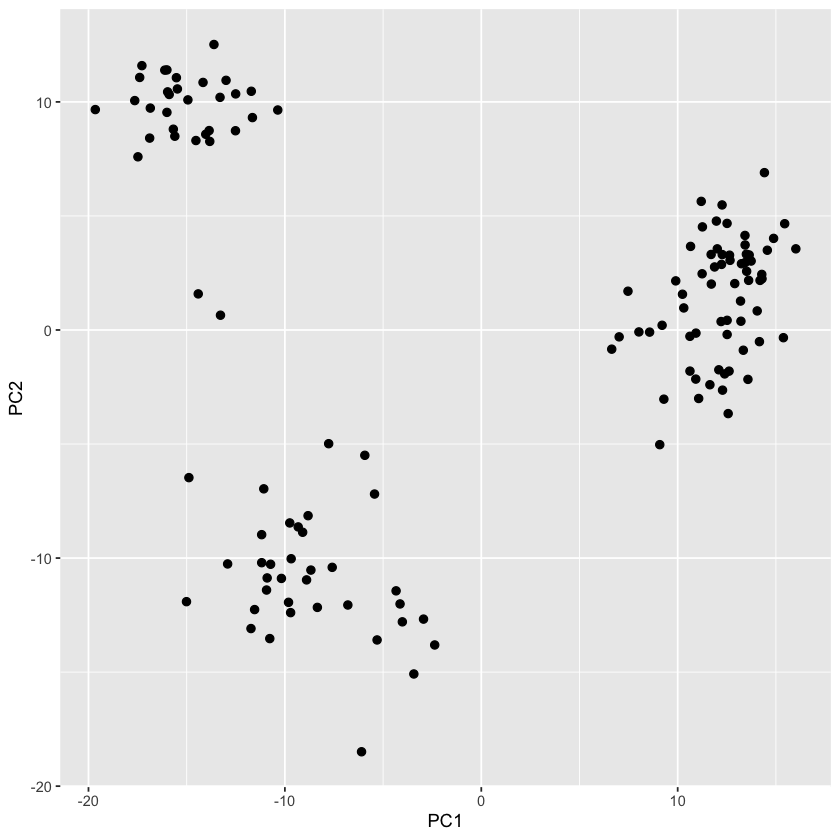

In [12]:
pca_df$phenology <- meta$phenology
pca_df$irrigation <- as.factor(meta$irrigation)
pca_df$replicate <- as.factor(meta$replicate)
pca_df$rootstock <- as.factor(meta$rootstock)
pca_df$row <- as.factor(meta$row)
pca_df$block <- as.factor(meta$block)

p <- ggplot(pca_df, aes(x=PC1, y=PC2)) + 
     geom_point(size=2)
p

Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”

pdf 
  2

Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”

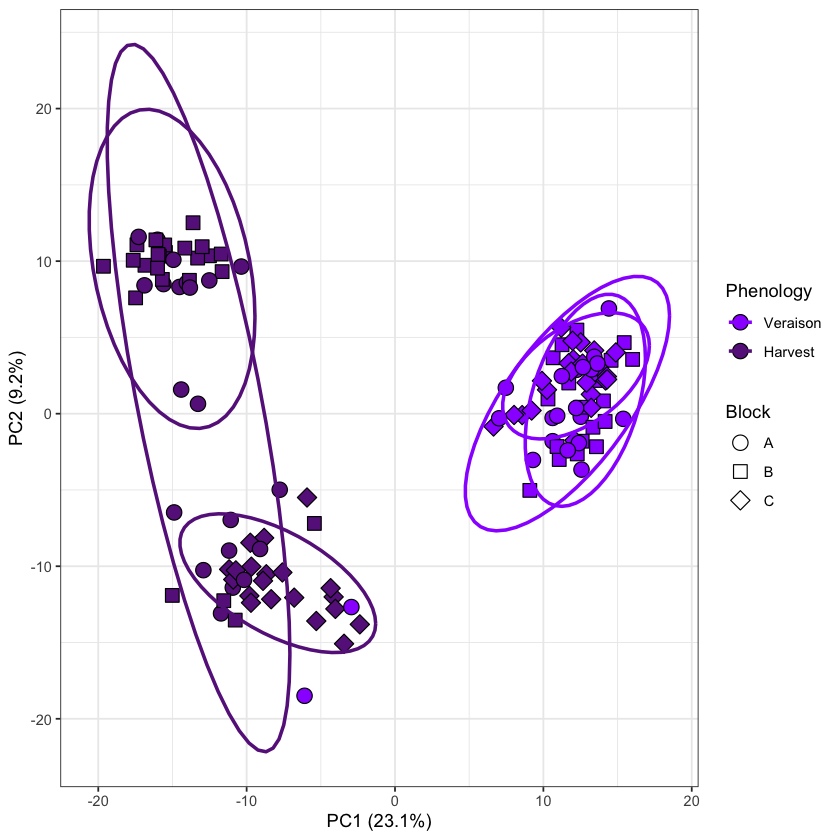

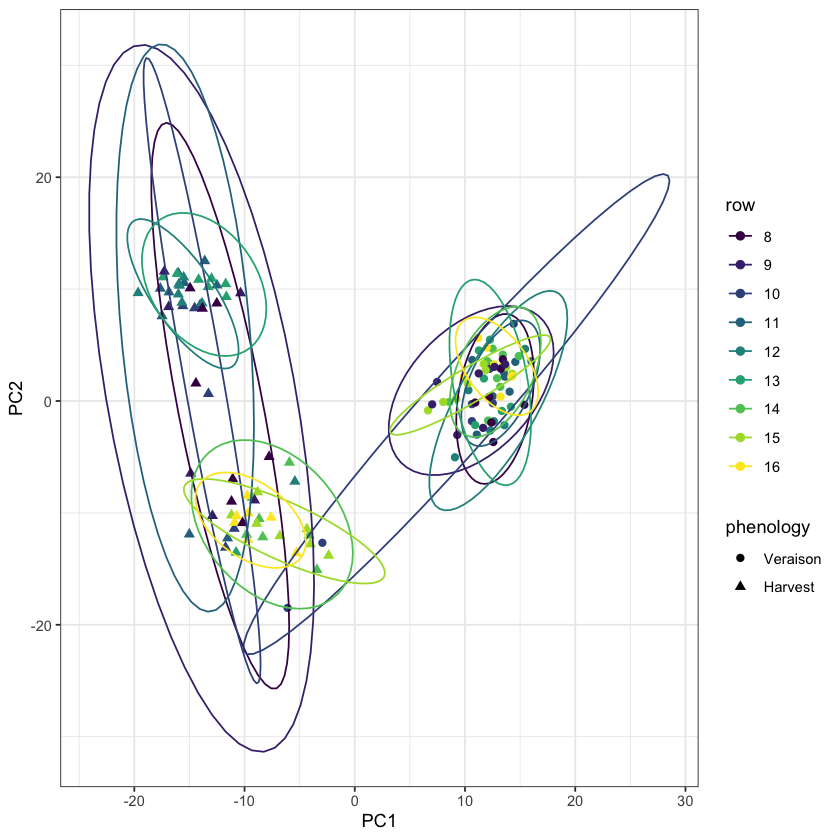

In [13]:
p <- ggplot(pca_df, aes(x=PC1, y=PC2, fill=phenology, shape=block)) + 
     geom_point(size=4) + 
     stat_ellipse(aes(color=phenology), lwd=1) + 
     scale_fill_manual('Phenology', values=p_palette) + 
     scale_color_manual('Phenology', values=p_palette) + 
     scale_shape_manual('Block', values=c(21, 22, 23)) + 
     guides(fill = guide_legend(override.aes = list(shape = 21))) +
     xlab("PC1 (23.1%)") + 
     ylab("PC2 (9.2%)") + 
     theme_bw()
p

pdf('2017_metabolomics_PCA_phenology.pdf')
  p
dev.off()

p <- ggplot(pca_df, aes(x=PC1, y=PC2, color=row, shape=phenology)) + 
     geom_point(size=2) + 
     stat_ellipse() + 
     scale_color_manual('row', values=row_palette) + 
     theme_bw()
p

## LMs on top 20 PCAs

Here, I fit linear models to each of the top 20 PCs. For each one, outliers more than 5 standard deviations are removed from the data set allowing for a maximum removal of 10% of the data. On each distribution, a linear model is fit to the design ```PC ~ block + irrigation + rootstock + phenology + block:rootstock + block:phenology + rootstock:phenology```. On each LM, a type-3 anova is fit under the assumption that interactions will be important determinants of variation. Each LM and anova are written to a list for future use. 

Following the linear models, I use the code from Zoe to reshape the summary of the outputs into a form that be plotted as a tile plot. 

In [14]:
vars <- c('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
          paste("PC", 11:20, sep=''))

# create a collector for models and anovas
models <- list(rep(0, length(vars)))
anovas <- list(rep(0, length(vars)))

# set the appropriate contrasts for type3 SS

oldc <- getOption("contrasts")
options(contrasts=c('contr.sum','contr.poly'))

for (idx in 1:length(vars)){
    # get variable name at index
    PC <- vars[idx]
    
    # get data
    d <- pca_df %>% dplyr::select(PC, phenology:block)
    
    # remove outliers and plot clean data
    d <- anomalize(as_tibble(d), target=PC, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    
    # fit lms
    colnames(d) <- c('PC', 'phenology', 'irrigation', 'replicate', 'rootstock', 'row', 'block')
    #model <- lm(PC ~ Irrigation + Leaf_index + Rootstock + Phenology + Irrigation:Leaf_index + Irrigation:Rootstock + Irrigation:Phenology + Leaf_index:Rootstock + Leaf_index:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
    model <- lm(PC ~ block + irrigation + rootstock + phenology + block:rootstock + block:phenology + rootstock:phenology, data=d, singular.ok=TRUE)
    models[[idx]] <- model
    
    # compute stats on model under type-3 SS
    stats <- car::Anova(model, type=3)
    anovas[[idx]] <- stats
    
}

# reset base contrasts so nothing is too broken
options(contrasts = oldc)

In [15]:
factors <- rownames(anovas[[1]])[2:length(rownames(anovas[[1]]))]

total_var_mat_p=matrix(,length(vars),length(factors)*2)
colnames(total_var_mat_p) <- c(factors, paste(factors, 'p', sep='_'))
rownames(total_var_mat_p) <- vars

for (idx in 1:length(vars)){
    range <- 2:(length(factors)+1)
    SS <- anovas[[idx]]$Sum[range]
    total_var <- sum(SS, na.rm=TRUE)
    var_exp <- SS/total_var * 100
    var_p <- anovas[[idx]]$Pr[range]
    mat_row <- c(var_exp, var_p)
    total_var_mat_p[idx,] <- mat_row
}

head(total_var_mat_p)

,block,irrigation,rootstock,phenology,block:rootstock,block:phenology,rootstock:phenology,Residuals,block_p,irrigation_p,rootstock_p,phenology_p,block:rootstock_p,block:phenology_p,rootstock:phenology_p,Residuals_p
PC1,1.590593,0.175022015,0.1605941,90.5882056,0.4509034,1.681698,0.1621905,5.190793,2.761932e-07,0.1535634,0.32622769,2.265990e-73,0.1436243,1.299429e-07,0.3217978,NA
PC2,18.930440,0.004230207,1.3627653,2.1561163,2.0243147,26.415409,0.2589728,48.847751,9.186176e-09,0.9951193,0.37304682,2.749667e-02,0.5869242,2.470642e-11,0.8964015,NA
PC3,46.841592,0.177608925,0.4885585,0.7778521,1.4122462,1.526261,0.3182423,48.457639,2.537560e-17,0.8132575,0.76777118,1.807361e-01,0.7699456,1.734060e-01,0.8630575,NA
PC4,6.575658,0.268927879,1.3859909,0.9621742,2.3203799,20.262195,0.6101564,67.614518,5.794185e-03,0.8022731,0.51976059,2.114621e-01,0.7020646,4.810846e-07,0.8008532,NA
PC5,5.089384,3.012504951,2.6623535,0.0262417,3.0197442,10.759559,1.3109718,74.119241,2.346685e-02,0.1052994,0.26089509,8.418258e-01,0.5971477,4.720010e-04,0.5745014,NA
PC6,3.009318,1.649184507,6.3775966,0.5303905,2.7705446,1.072738,0.9273831,83.662845,1.357983e-01,0.3319045,0.03952271,3.991238e-01,0.7109985,4.868270e-01,0.7407587,NA


In [16]:
total_var_mat_p <- data.frame(total_var_mat_p)

total_var_mat_p$variable <- rownames(total_var_mat_p)
total_var_mat_p$Residuals <- NULL
total_var_mat_p$Residuals_p <- NULL

head(total_var_mat_p)

write.csv(total_var_mat_p, file='2017_metabolomics_var_p.csv', quote=F)

,block,irrigation,rootstock,phenology,block.rootstock,block.phenology,rootstock.phenology,block_p,irrigation_p,rootstock_p,phenology_p,block.rootstock_p,block.phenology_p,rootstock.phenology_p,variable
PC1,1.590593,0.175022015,0.1605941,90.5882056,0.4509034,1.681698,0.1621905,2.761932e-07,0.1535634,0.32622769,2.265990e-73,0.1436243,1.299429e-07,0.3217978,PC1
PC2,18.930440,0.004230207,1.3627653,2.1561163,2.0243147,26.415409,0.2589728,9.186176e-09,0.9951193,0.37304682,2.749667e-02,0.5869242,2.470642e-11,0.8964015,PC2
PC3,46.841592,0.177608925,0.4885585,0.7778521,1.4122462,1.526261,0.3182423,2.537560e-17,0.8132575,0.76777118,1.807361e-01,0.7699456,1.734060e-01,0.8630575,PC3
PC4,6.575658,0.268927879,1.3859909,0.9621742,2.3203799,20.262195,0.6101564,5.794185e-03,0.8022731,0.51976059,2.114621e-01,0.7020646,4.810846e-07,0.8008532,PC4
PC5,5.089384,3.012504951,2.6623535,0.0262417,3.0197442,10.759559,1.3109718,2.346685e-02,0.1052994,0.26089509,8.418258e-01,0.5971477,4.720010e-04,0.5745014,PC5
PC6,3.009318,1.649184507,6.3775966,0.5303905,2.7705446,1.072738,0.9273831,1.357983e-01,0.3319045,0.03952271,3.991238e-01,0.7109985,4.868270e-01,0.7407587,PC6


variable,factor,var
PC01,block,1.590593
PC02,block,18.930440
PC03,block,46.841592
PC04,block,6.575658
PC05,block,5.089384
PC06,block,3.009318


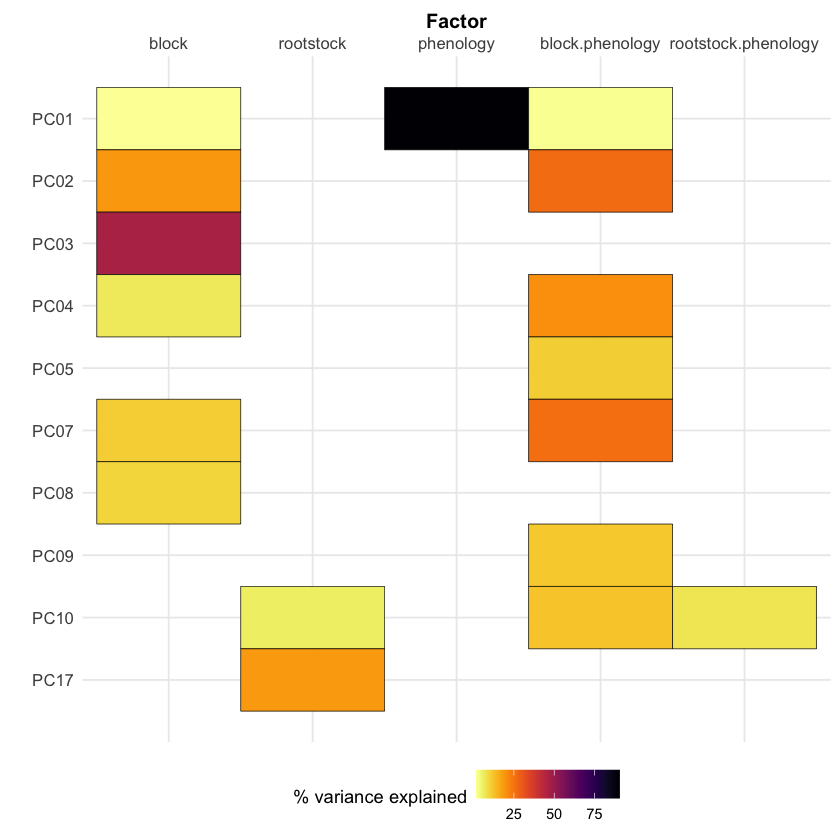

In [17]:
total_var_mat_p$variable <- c('PC01', 'PC02', 'PC03', 'PC04', 'PC05', 'PC06', 'PC07', 'PC08', 'PC09', 'PC10',
                               paste('PC', 11:20, sep=''))

# Get variance columns
total_var <- total_var_mat_p %>% dplyr::select(variable, block:rootstock.phenology)

# reorganize and rename to format for plotting
total_var <- total_var %>% gather(key=factor, value=var, -variable)

total_var <- total_var %>% mutate(factor=str_replace(factor, "_var" %R% END, ""))
head(total_var)

#get p-value columns
total_p <- total_var_mat_p %>% dplyr::select(block_p:rootstock.phenology_p)
total_p <- data.frame(t(apply(total_p, 1, FUN=p.adjust, method='fdr')))
total_p$variable <- total_var_mat_p$variable

#reorganize and rename to format for plotting
total_p <- total_p %>% gather(key=factor, value=p_value, -variable)
total_p <- total_p %>% mutate(factor=str_replace(factor,"_p" %R% END, ""))

#join variance and p-value tables back together 
total_var_p <- full_join(total_var, total_p,by=c("variable", "factor"))

#elements need a number for y-axis when plotting, there are 20 elements here 
total_var_p <- total_var_p %>% arrange(variable) %>% mutate(var_number=rep(1:20, each=7))

#only plot significant p_values
total_var_p_sig <- total_var_p %>% filter(p_value < 0.05) 
write.table(total_var_p_sig[,c("variable", "factor","var", "p_value")], "2017_metabolomics_var_p_sig.txt", sep="\t", row.names=F, quote=F, col.names=T)

var_number_fix <- rep(0, dim(total_var_p_sig)[1])
unique_variable_names <- unique(total_var_p_sig$variable)
for (idx in 1:length(var_number_fix)){
    var_number_fix[idx] <- which(unique_variable_names == total_var_p_sig$variable[[idx]])
}

total_var_p_sig$var_number <- var_number_fix
total_var_p_sig$factor <- factor(total_var_p_sig$factor, levels=c('block', 'irrigation', 'rootstock', 'phenology', 'block.rootstock', 'block.phenology', 'rootstock.phenology'))
# total_var_p_sig$variable <- factor(total_var_p_sig$variable, levels=c('PC1', 'PC2','PC3','PC4','PC5','PC6','PC7',
#                                                                       'PC8','PC9','PC10', 'PC11', 'PC12', 'PC13', 
#                                                                       'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20'))
# total_var_p_sig$var_number <- factor(total_var_p_sig$var_number, levels=c('1', '8', '9', '10', '11','12','13', '2','3','4','5','6','7'))


#make plot
t <- ggplot(data=total_var_p_sig, aes(x=factor, y=as.numeric(as.character(var_number)), fill=var)) + 
    geom_tile(color="black", size=0.2)+
    theme_minimal() +
    labs(x = "Factor", y="") + 
    theme(axis.text=element_text(size=10),axis.title=element_text(size=12,face="bold"),legend.position = "bottom") +
    scale_y_continuous(trans="reverse", breaks = 1:length(unique(total_var_p_sig$variable)), minor_breaks=NULL, labels=unique(total_var_p_sig[,"variable"])) +
    scale_x_discrete(position = "top") + 
    scale_fill_viridis(option="inferno", name="% variance explained", direction = -1)
t

# pdf("metabolomics_variance_heatmap_black_viridis.pdf", width=12, height=4)
#   t
# dev.off()

It looks like PC17 is significant for rootstock, so I plot its distribution to see what it looks like. 

pdf 
  2

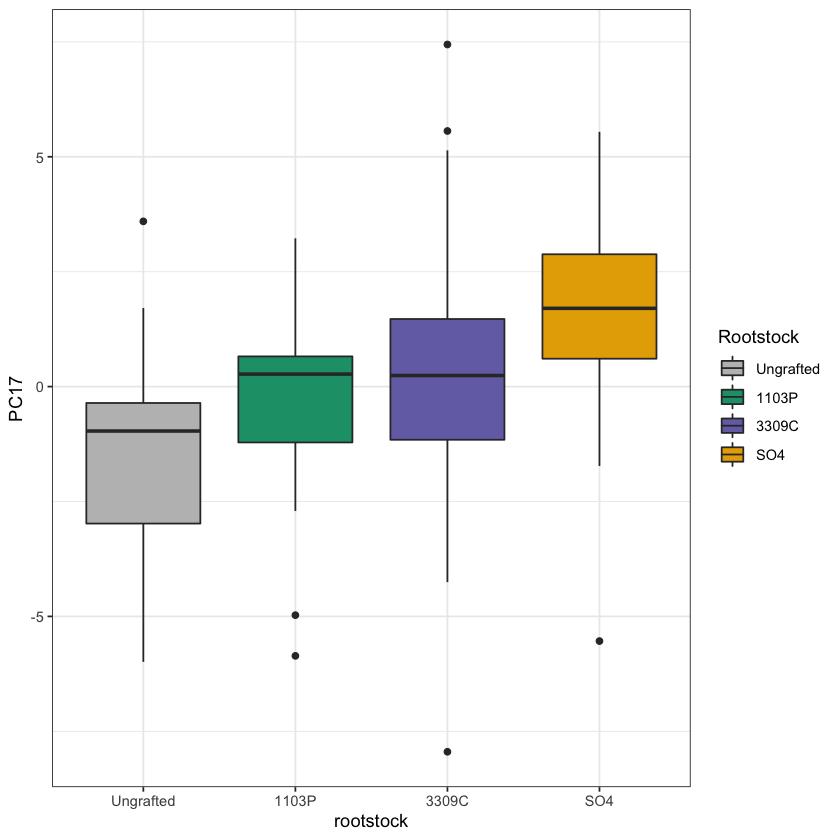

In [18]:
p <- ggplot(pca_df, aes(y=PC17, x=rootstock, fill=rootstock)) + 
     geom_boxplot() + 
     scale_fill_manual(name='Rootstock', values=rs_palette) + 
     theme_bw()
p

pdf('2017_metabolomics_PC17_rootstock.pdf')
  p
dev.off()

### Following the LMs, I fit a post-hoc comparison of means to see if the result is convincing

In [24]:
vars[17]

[1] "PC17"

In [19]:
# get variable name at index
PC <- vars[17]

# get data
d <- pca_df %>% dplyr::select(PC, phenology:block)

# remove outliers and plot clean data
d <- anomalize(as_tibble(d), target=PC, method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]

# fit lms
colnames(d) <- c('PC', 'phenology', 'irrigation', 'replicate', 'rootstock', 'row', 'block')
#model <- lm(PC ~ Irrigation + Leaf_index + Rootstock + Phenology + Irrigation:Leaf_index + Irrigation:Rootstock + Irrigation:Phenology + Leaf_index:Rootstock + Leaf_index:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
model <- lm(PC ~ block + irrigation + rootstock + phenology + block:rootstock + block:phenology + rootstock:phenology, data=d, singular.ok=TRUE)

In [20]:
emm <- emmeans(models[[17]], ~rootstock)
res <- pairs(emm)
res <- as.data.frame(res)
res[res$p.value < 0.05,]

NOTE: Results may be misleading due to involvement in interactions


,contrast,estimate,SE,df,t.ratio,p.value
2,Ungrafted - 3309C,-1.639279,0.5660488,113,-2.896002,2.318561e-02
3,Ungrafted - SO4,-2.984581,0.5805005,113,-5.141393,6.843715e-06
5,1103P - SO4,-1.889965,0.5872477,113,-3.218343,9.006560e-03


It looks like there is a real difference between three of the tested contrasts! Ungrafted seems to be different from 3309C and SO4, and 1103P seems different from SO4.

Next, I ask if any of the heavy loaders (more than 1.96 sd from the mean) show any interesting signals of rootstock differences. Here, I use the same method of fitting Linear Models to each of the 39 metabolites, and constructing a tile plot to summarize the results. For the 4 metabolites that appear significant to rootstock, I compute post-hoc comparisons of means to assess whether or not there are differences. 

In [21]:
x <- as.data.frame(pca$rotation)
write.csv(x, file='2017_metabolomics_loadings.csv')

[1] -0.07132003  0.08025575


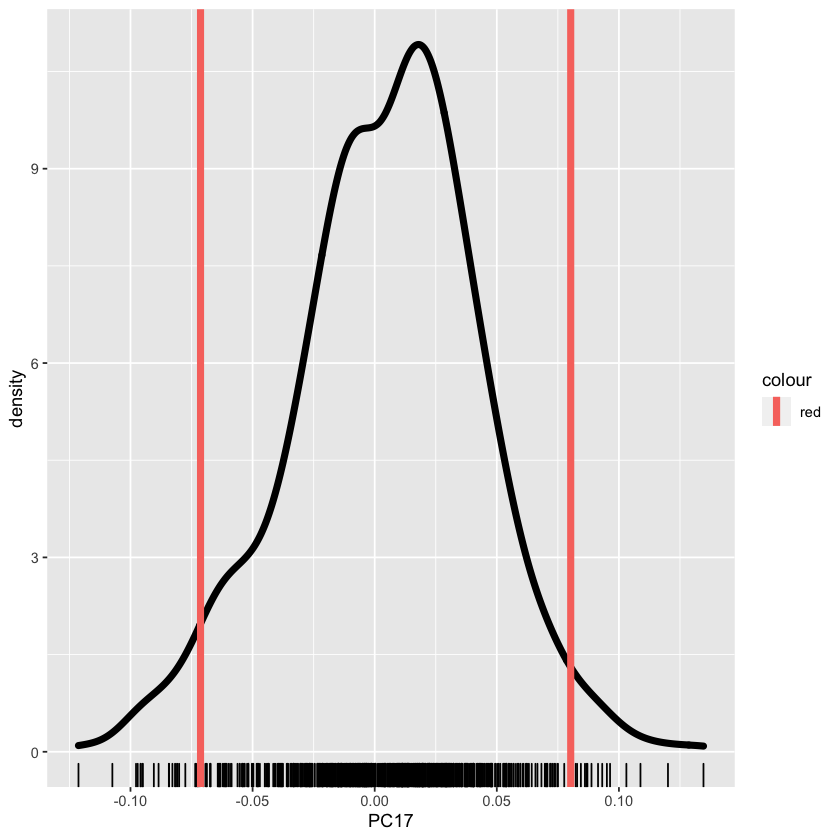

In [28]:
m <- mean(x$PC17)
s <- sd(x$PC17)

us <- m + (s * 1.96)
ls <- m - (s * 1.96)

print(c(ls, us))

p <- ggplot(x, aes(x=PC17)) + 
     geom_density(lwd=2) + 
     geom_rug() + 
     geom_vline(aes(xintercept=us, color='red'), lwd=2) + 
     geom_vline(aes(xintercept=ls, color='red'), lwd=2)
p

In [29]:
vars <- c(rownames(x[x$PC17 > us,]), rownames(x[x$PC17 < ls,]))
length(vars)

[1] 39

In [31]:
metab_models <- list(rep(0, length(vars)))
metab_anovas <- list(rep(0, length(vars)))

# set the appropriate contrasts for type3 SS
oldc <- getOption("contrasts")
options(contrasts=c('contr.sum','contr.poly'))


pdf('metabolomics_heavily_loading_pcs.pdf', onefile=T)
for (idx in 1:length(vars)){ 
    # get element name at index
    metab <- vars[idx]
    
    #extract data
    d <- meta[,c('rootstock', 'phenology', 'irrigation', 'block')]
    d$metab <- data_sub[,metab]  
    d_norm <- as.vector(scale(d$metab, scale=TRUE, center=TRUE))
    d$metab <- d_norm
    
    # remove outliers, fix colnames
    d <- anomalize(as_tibble(d), target=metab, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    colnames(d) <- c('Rootstock', 'Phenology', 'Irrigation', 'Block', 'metab', 'e1', 'e2', 'anomaly')

    # fit LM
    model <- lm(metab ~ Block + Irrigation + Rootstock + Phenology + Block:Rootstock + Block:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
    metab_models[[idx]] <- model
    
    # compute stats on model under type-3 SS
    stats <- car::Anova(model, type=3)
    metab_anovas[[idx]] <- stats
        
    p <- ggplot(d, aes(x=Rootstock, y=metab, fill=Rootstock)) + 
         geom_boxplot() +
         ylab(metab) + 
         scale_fill_manual(name='Rootstock', values=rs_palette) +
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    print(p)
}
dev.off()

# reset base contrasts so nothing is too broken
options(contrasts = oldc)

pdf 
  2

In [32]:
factors <- rownames(metab_anovas[[1]])[2:length(rownames(metab_anovas[[1]]))]

total_var_mat_p=matrix(,length(vars),length(factors)*2)
colnames(total_var_mat_p) <- c(factors, paste(factors, 'p', sep='_'))
rownames(total_var_mat_p) <- vars

for (idx in 1:length(vars)){
    range <- 2:(length(factors)+1)
    SS <- metab_anovas[[idx]]$Sum[range]
    total_var <- sum(SS, na.rm=TRUE)
    var_exp <- SS/total_var * 100
    var_p <- metab_anovas[[idx]]$Pr[range]
    mat_row <- c(var_exp, var_p)
    total_var_mat_p[idx,] <- mat_row
}

head(total_var_mat_p)

,Block,Irrigation,Rootstock,Phenology,Block:Rootstock,Block:Phenology,Rootstock:Phenology,Residuals,Block_p,Irrigation_p,Rootstock_p,Phenology_p,Block:Rootstock_p,Block:Phenology_p,Rootstock:Phenology_p,Residuals_p
X98,0.4178820,0.932416747,2.5304434,42.513370,1.8864000,0.931586,1.9334874,48.85441,0.6180263,0.34363467,0.12543433,4.727060e-17,0.62859233,0.3439587967,0.22090458,NA
X179,0.9253301,0.006482728,1.9146003,41.625707,2.3572276,2.276610,0.5534856,50.34056,0.3638894,0.99287879,0.24450496,3.318697e-16,0.52216925,0.0858767677,0.74840142,NA
X227,0.8127541,0.642553212,1.3820770,37.657066,1.8464478,2.201412,0.1908764,55.26681,0.4383055,0.52042920,0.42294784,2.066556e-14,0.70658561,0.1100449398,0.94203058,NA
X253,2.4759807,0.488932702,5.1305802,3.413647,4.6527476,1.812130,0.4937511,81.53223,0.1844712,0.71333261,0.07428649,3.170449e-02,0.38188429,0.2888021592,0.87666551,NA
X271,1.5822951,2.566150132,4.7319332,30.474425,0.4016895,8.150929,3.2529325,48.83965,0.1677123,0.05683075,0.01543316,1.931113e-13,0.98800221,0.0001763153,0.06423588,NA
X273,2.1283928,0.861121886,0.8104918,23.986297,6.3280966,5.138601,2.2518053,58.49519,0.1327512,0.43793386,0.66808359,5.035133e-10,0.06634675,0.0085887219,0.23208328,NA


In [33]:
total_var_mat_p <- data.frame(total_var_mat_p)

total_var_mat_p$variable <- rownames(total_var_mat_p)
total_var_mat_p$Residuals <- NULL
total_var_mat_p$Residuals_p <- NULL

head(total_var_mat_p)

write.csv(total_var_mat_p, file='2017_metabolomites_var_p.csv', quote=F)

,Block,Irrigation,Rootstock,Phenology,Block.Rootstock,Block.Phenology,Rootstock.Phenology,Block_p,Irrigation_p,Rootstock_p,Phenology_p,Block.Rootstock_p,Block.Phenology_p,Rootstock.Phenology_p,variable
X98,0.4178820,0.932416747,2.5304434,42.513370,1.8864000,0.931586,1.9334874,0.6180263,0.34363467,0.12543433,4.727060e-17,0.62859233,0.3439587967,0.22090458,X98
X179,0.9253301,0.006482728,1.9146003,41.625707,2.3572276,2.276610,0.5534856,0.3638894,0.99287879,0.24450496,3.318697e-16,0.52216925,0.0858767677,0.74840142,X179
X227,0.8127541,0.642553212,1.3820770,37.657066,1.8464478,2.201412,0.1908764,0.4383055,0.52042920,0.42294784,2.066556e-14,0.70658561,0.1100449398,0.94203058,X227
X253,2.4759807,0.488932702,5.1305802,3.413647,4.6527476,1.812130,0.4937511,0.1844712,0.71333261,0.07428649,3.170449e-02,0.38188429,0.2888021592,0.87666551,X253
X271,1.5822951,2.566150132,4.7319332,30.474425,0.4016895,8.150929,3.2529325,0.1677123,0.05683075,0.01543316,1.931113e-13,0.98800221,0.0001763153,0.06423588,X271
X273,2.1283928,0.861121886,0.8104918,23.986297,6.3280966,5.138601,2.2518053,0.1327512,0.43793386,0.66808359,5.035133e-10,0.06634675,0.0085887219,0.23208328,X273


variable,factor,var
X98,Block,0.4178820
X179,Block,0.9253301
X227,Block,0.8127541
X253,Block,2.4759807
X271,Block,1.5822951
X273,Block,2.1283928


pdf 
  2

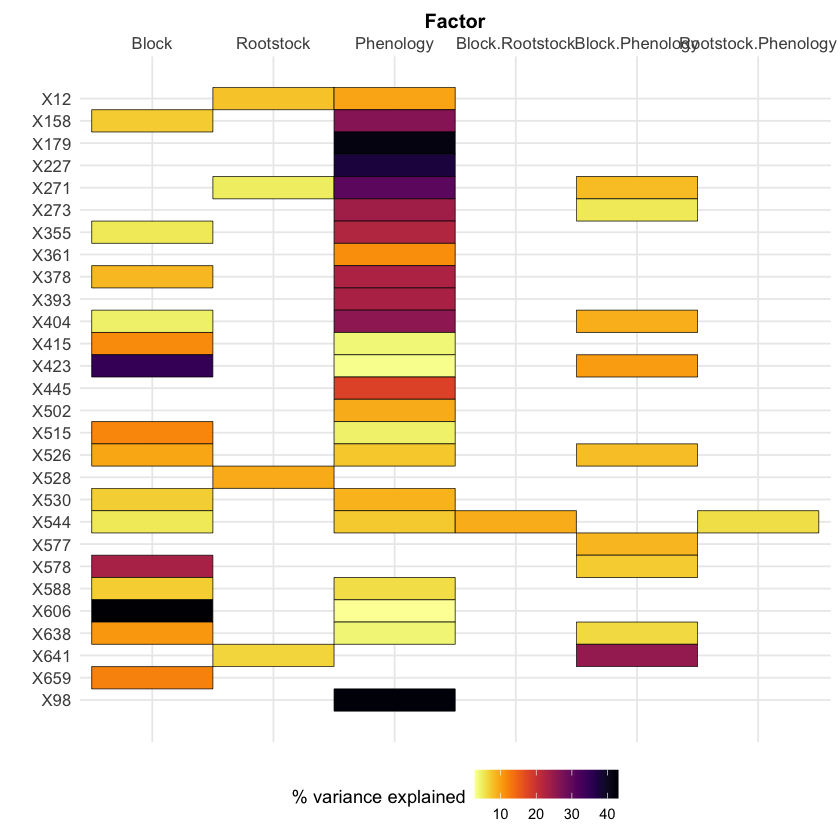

In [40]:
# Get variance columns
total_var <- total_var_mat_p %>% dplyr::select(variable, Block:Rootstock.Phenology)

# reorganize and rename to format for plotting
total_var <- total_var %>% gather(key=factor, value=var, -variable)

total_var <- total_var %>% mutate(factor=str_replace(factor, "_var" %R% END, ""))
head(total_var)

#get p-value columns
total_p <- total_var_mat_p %>% dplyr::select(Block_p:Rootstock.Phenology_p)
total_p <- data.frame(t(apply(total_p, 1, FUN=p.adjust, method='fdr')))
total_p$variable <- total_var_mat_p$variable

#reorganize and rename to format for plotting
total_p <- total_p %>% gather(key=factor, value=p_value, -variable)
total_p <- total_p %>% mutate(factor=str_replace(factor,"_p" %R% END, ""))

#join variance and p-value tables back together 
total_var_p <- full_join(total_var, total_p,by=c("variable", "factor"))

#elements need a number for y-axis when plotting, there are 20 elements here 
total_var_p <- total_var_p %>% arrange(variable) %>% mutate(var_number=rep(1:39, each=7))

#only plot significant p_values
total_var_p_sig <- total_var_p %>% filter(p_value < 0.05) 
write.table(total_var_p_sig[,c("variable", "factor","var", "p_value")], "2017_metabolomites_var_p_sig.txt", sep="\t", row.names=F, quote=F, col.names=T)

var_number_fix <- rep(0, dim(total_var_p_sig)[1])
unique_variable_names <- unique(total_var_p_sig$variable)
for (idx in 1:length(var_number_fix)){
    var_number_fix[idx] <- which(unique_variable_names == total_var_p_sig$variable[[idx]])
}

total_var_p_sig$var_number <- var_number_fix
total_var_p_sig$factor <- factor(total_var_p_sig$factor, levels=c('Block', 'Irrigation', 'Rootstock', 'Phenology', 'Block.Rootstock', 'Block.Phenology', 'Rootstock.Phenology'))

#make plot
t <- ggplot(data=total_var_p_sig, aes(x=factor, y=as.numeric(as.character(var_number)), fill=var)) + 
    geom_tile(color="black", size=0.2)+
    theme_minimal() +
    labs(x = "Factor", y="") + 
    theme(axis.text=element_text(size=10),axis.title=element_text(size=12,face="bold"),legend.position = "bottom") +
    scale_y_continuous(trans="reverse", breaks = 1:length(unique(total_var_p_sig$variable)), minor_breaks=NULL, labels=unique(total_var_p_sig[,"variable"])) +
    scale_x_discrete(position = "top") + 
    scale_fill_viridis(option="inferno", name="% variance explained", direction = -1)
t

pdf("metabolomites_variance_heatmap_black_viridis.pdf", width=8, height=6)
  t
dev.off()

NOTE: Results may be misleading due to involvement in interactions


           contrast   estimate         SE  df t.ratio     p.value
1 Ungrafted - 1103P 0.08448325 0.02507666 111   3.369 0.005649216


NOTE: Results may be misleading due to involvement in interactions


     contrast   estimate        SE  df   t.ratio    p.value
5 1103P - SO4 -0.4142746 0.1321037 112 -3.135981 0.01158502


NOTE: Results may be misleading due to involvement in interactions


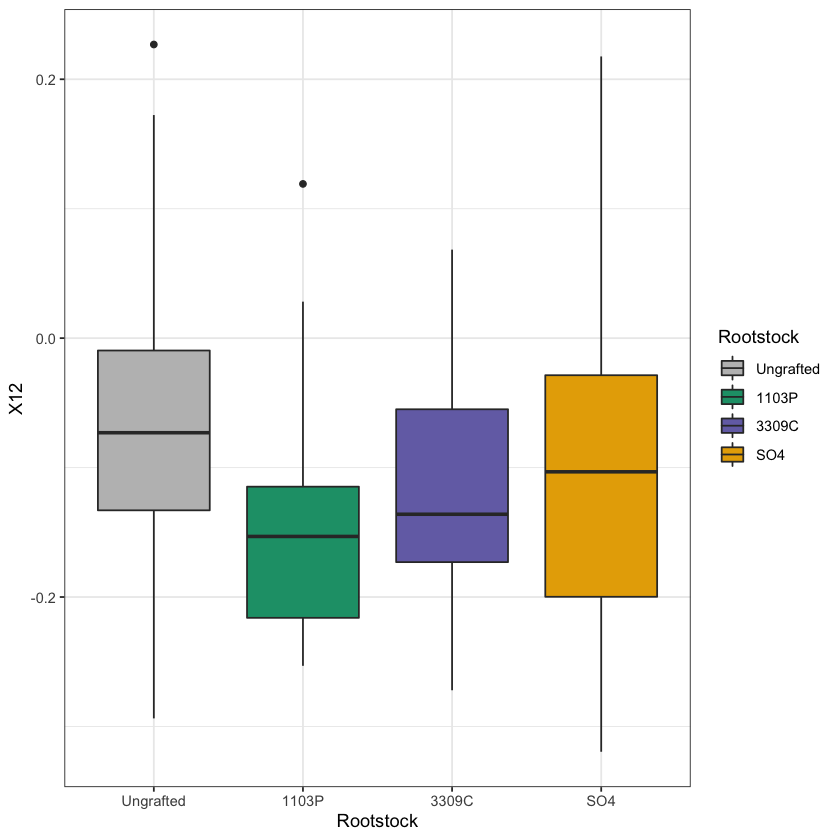

         contrast   estimate      SE  df   t.ratio     p.value
3 Ungrafted - SO4 -0.3847508 0.11295 112 -3.406381 0.004999937


NOTE: Results may be misleading due to involvement in interactions


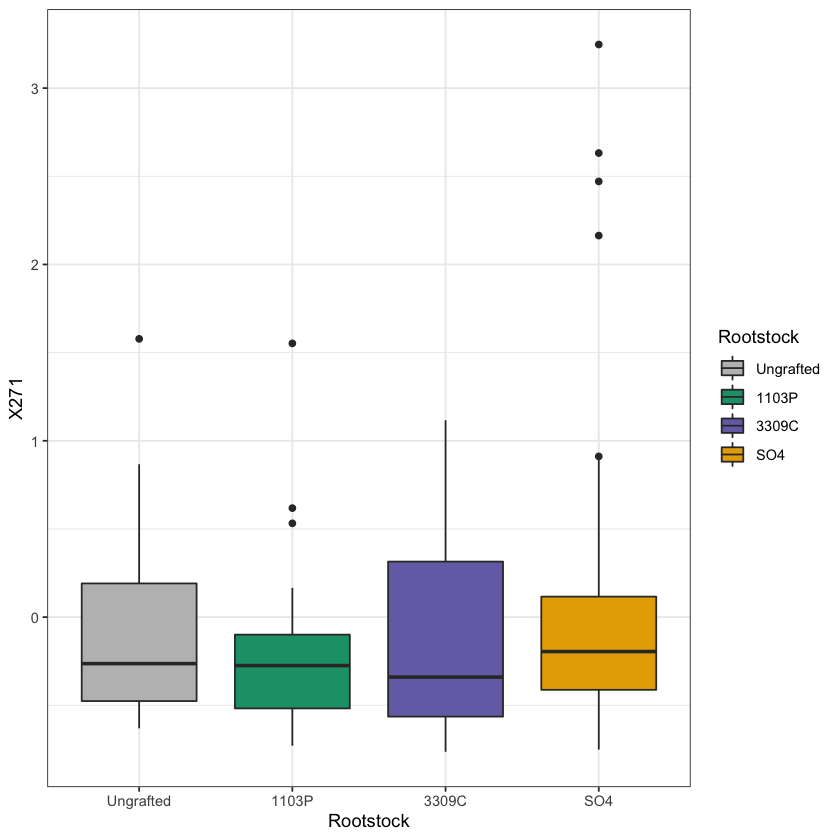

         contrast  estimate        SE  df  t.ratio     p.value
3 Ungrafted - SO4 0.6945428 0.2074134 113 3.348592 0.005998562


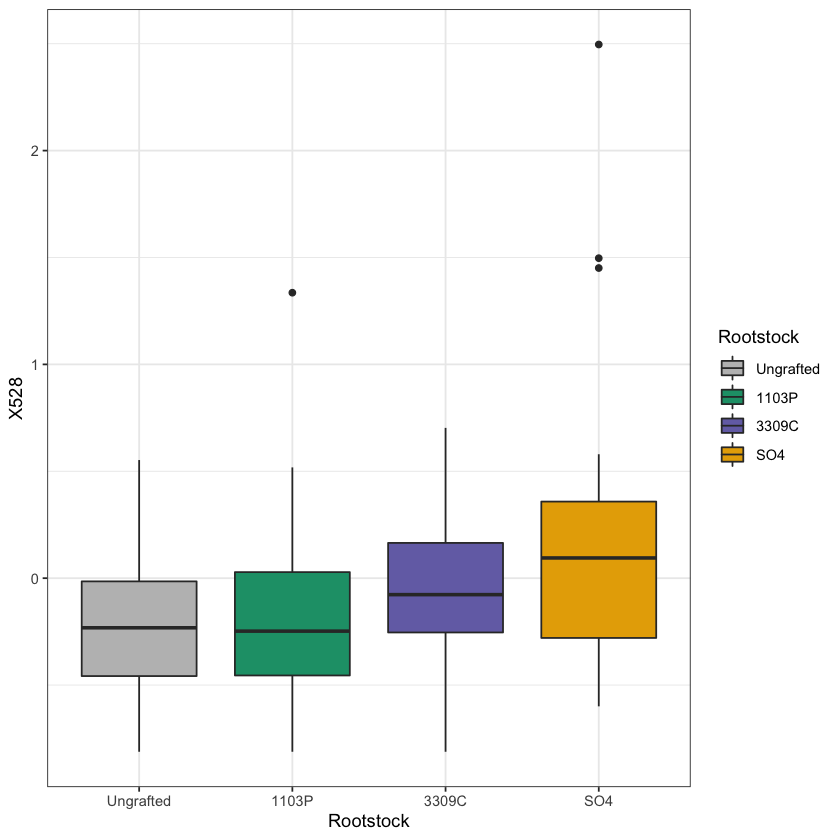

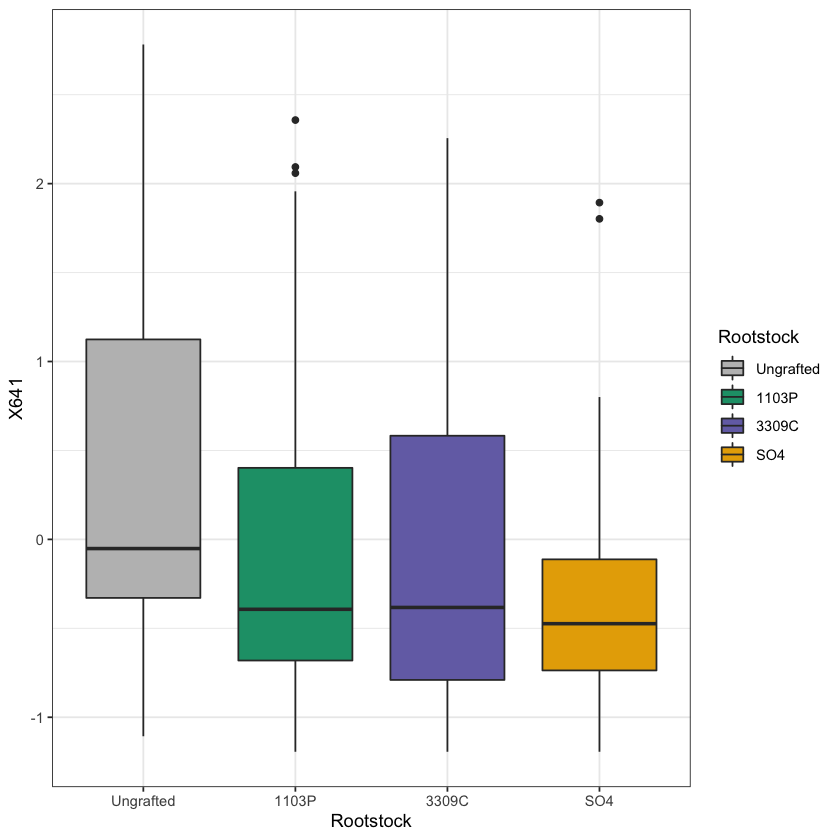

In [35]:
p.cutoff <- 0.05/(4)

vars <- c('X12', 'X271', 'X528', 'X641')

for (idx in 1:length(vars)){
    # get element name at index
    metab <- vars[idx]
    
    #extract data
    d <- meta[,c('rootstock', 'phenology', 'irrigation', 'block')]
    d$metab <- data_sub[,metab]  
    d_norm <- as.vector(scale(d$metab, scale=TRUE, center=TRUE))
    d$metab <- d_norm
    
    # remove outliers, fix colnames
    d <- anomalize(as_tibble(d), target=metab, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    colnames(d) <- c('Rootstock', 'Phenology', 'Irrigation', 'Block', 'metab', 'e1', 'e2', 'anomaly')

    # fit LM
    model <- lm(metab ~ Block + Irrigation + Rootstock + Phenology + Block:Rootstock + Block:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)

    emm <- emmeans(model, ~Rootstock)
    res <- pairs(emm)
    res <- as.data.frame(res)
    print(res[res$p.value < p.cutoff,])
    
    p <- ggplot(d, aes(x=Rootstock, y=metab, fill=Rootstock)) + 
         geom_boxplot() + 
         scale_fill_manual('Rootstock', values=rs_palette) + 
         ylab(metab) + 
         theme_bw()
    print(p)       
}

### LDA

In order to visualize class seperability, I fit an LDA to several factors of the experimental design. I try not to dwell too much on these because they may be overfit, but provide a nice scaffolding for some future work. 

In [22]:
library('MASS')


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



Warning message in lda.default(x, grouping, ...):
“group SO4-overgrowth is empty”Warning message in lda.default(x, grouping, ...):
“variables are collinear”

pdf 
  2

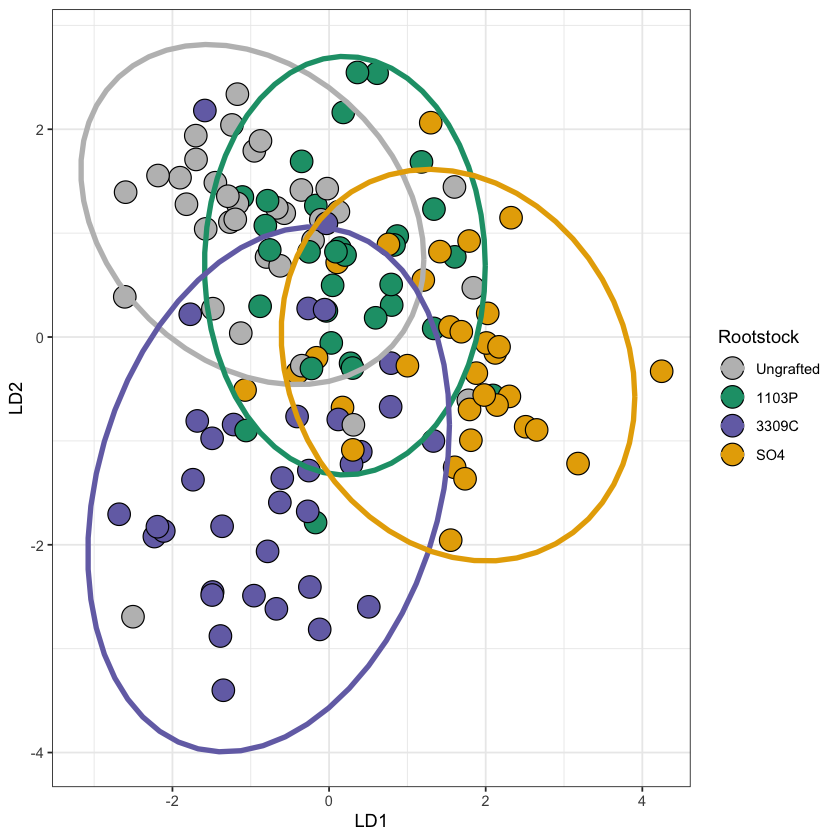

In [30]:
lda.rs <- lda(data_sub, grouping=meta$rootstock)
for_plot <- as.data.frame(predict(lda.rs, data_sub))
for_plot$Rootstock <- meta$rootstock

rs.lda <- ggplot(for_plot, aes(x=x.LD1, y=x.LD2, fill=Rootstock)) + 
               geom_point(aes(shape=Rootstock), size=6) + 
               stat_ellipse(aes(color=Rootstock), lwd=1.5) + scale_color_manual('Rootstock', values=rs_palette) +
               scale_shape_manual(values=c(21, 21, 21, 21)) + 
               scale_fill_manual('Rootstock', values=rs_palette) + 
               xlab('LD1') + ylab('LD2') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
rs.lda

# p <- ggplot(for_plot, aes(x=Rootstock, y=x.LD1, fill=Rootstock)) + 
#                geom_boxplot() + 
#                scale_fill_manual('Rootstock', values=rs_palette) + 
#                xlab('Rootstock') + ylab('LD1') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p

# p <- ggplot(for_plot, aes(x=Rootstock, y=x.LD2, fill=Rootstock)) + 
#                geom_boxplot() + 
#                scale_fill_manual('Rootstock', values=rs_palette) + 
#                xlab('Rootstock') + ylab('LD2') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p

# p <- ggplot(for_plot, aes(x=Rootstock, y=x.LD3, fill=Rootstock)) + 
#                geom_boxplot() + 
#                scale_fill_manual('Rootstock', values=rs_palette) + 
#                xlab('Rootstock') + ylab('LD3') + theme_bw() + 
#                guides(fill = guide_legend(override.aes = list(shape = 21)))           
# p

pdf('2017_metabolomics_LDA_rootstock.pdf')
  rs.lda
dev.off()


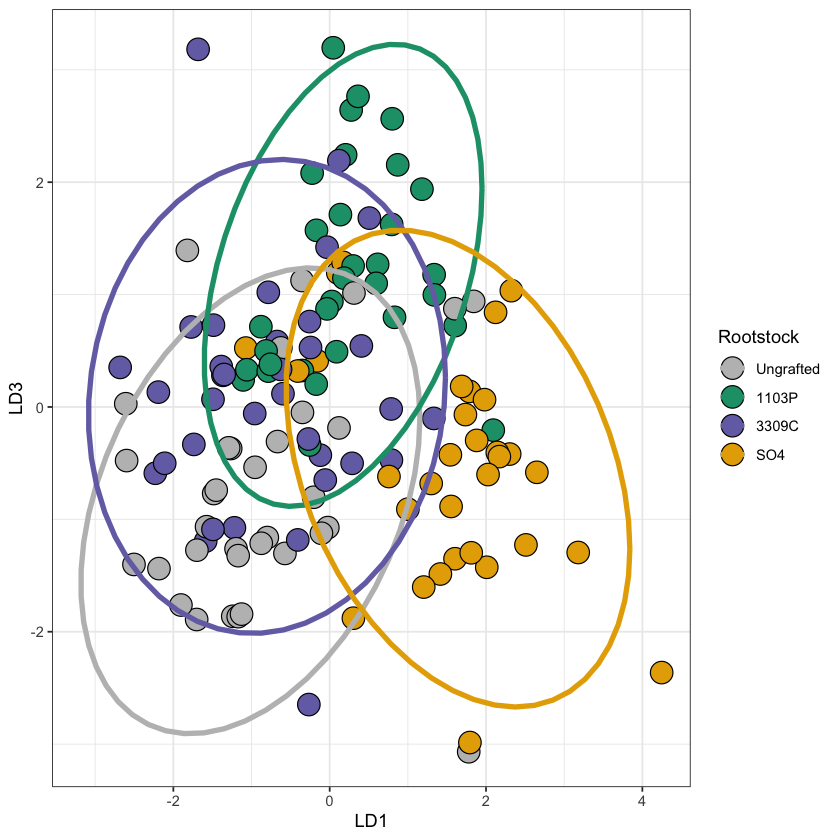

In [25]:
rs.lda <- ggplot(for_plot, aes(x=x.LD1, y=x.LD3, fill=Rootstock)) + 
               geom_point(aes(shape=Rootstock), size=6) + 
               stat_ellipse(aes(color=Rootstock), lwd=1.5) + scale_color_manual('Rootstock', values=rs_palette) +
               scale_shape_manual(values=c(21, 21, 21, 21)) + 
               scale_fill_manual('Rootstock', values=rs_palette) + 
               xlab('LD1') + ylab('LD3') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
rs.lda

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

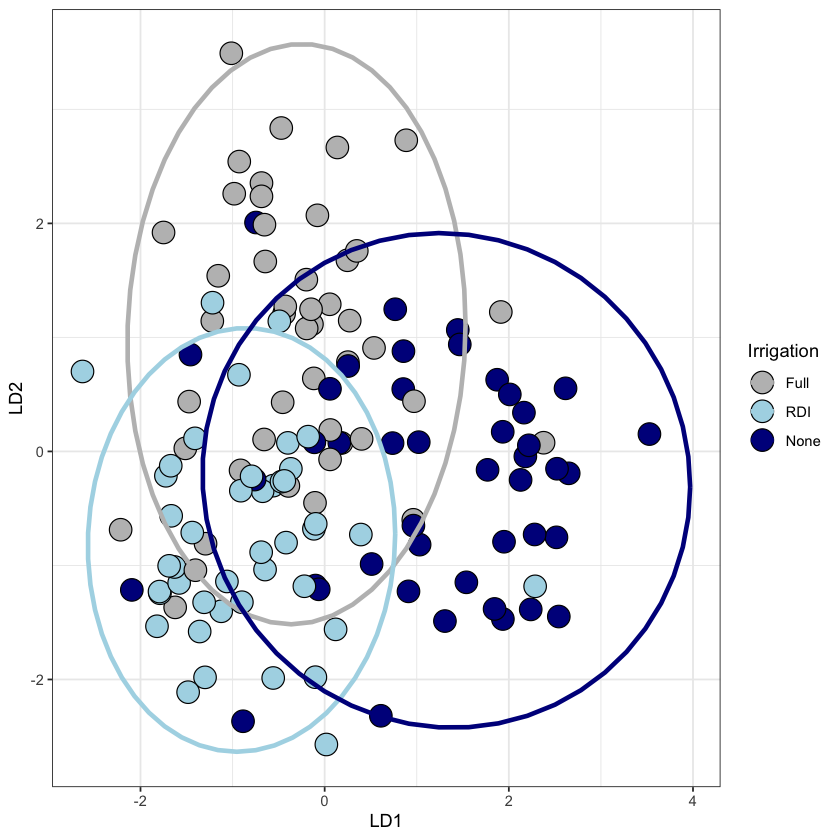

In [49]:
lda.irrigation <- lda(data_sub, grouping=meta$irrigation)
for_plot <- as.data.frame(predict(lda.irrigation, data_sub))
for_plot$Irrigation <- meta$irrigation

i.lda <- ggplot(for_plot, aes(x=x.LD1, y=x.LD2, fill=Irrigation)) + 
               geom_point(aes(shape=Irrigation), size=6) + 
               stat_ellipse(aes(color=Irrigation), lwd=1.3) + scale_color_manual('Irrigation', values=i_palette) +
               scale_shape_manual(values=c(21, 21, 21, 21)) + 
               scale_fill_manual('Irrigation', values=i_palette) + 
               xlab('LD1') + ylab('LD2') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
i.lda

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

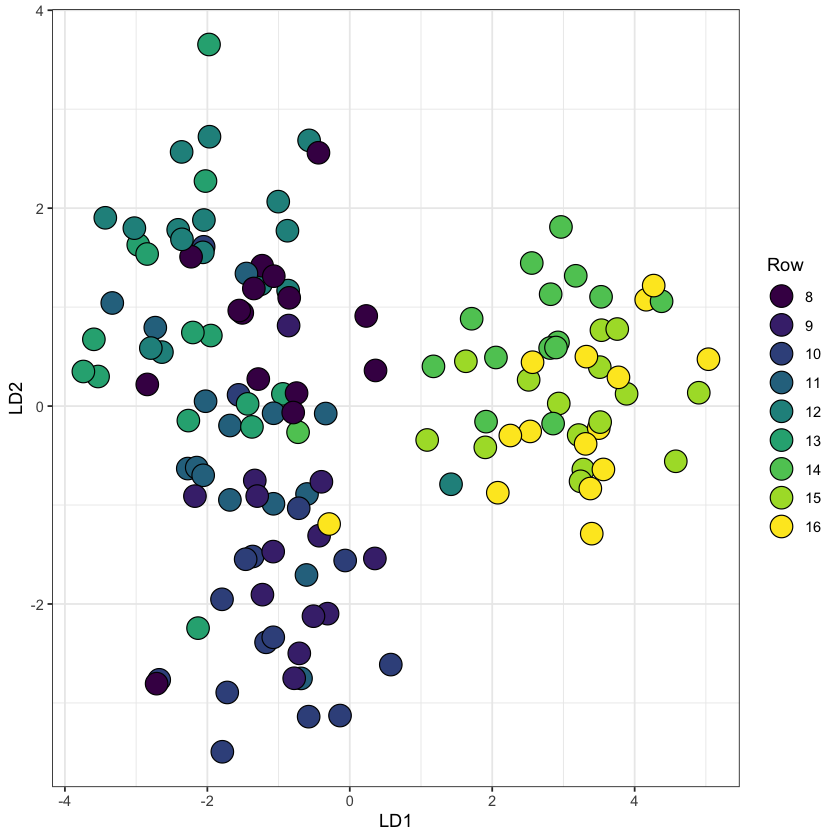

In [52]:
lda.row <- lda(data_sub, grouping=as.factor(meta$row))
for_plot <- as.data.frame(predict(lda.row, data_sub))
for_plot$Row <- as.factor(meta$row)

r.lda <- ggplot(for_plot, aes(x=x.LD1, y=x.LD2, fill=Row)) + 
               geom_point(aes(shape=Row), size=6) + 
               #stat_ellipse(aes(color=Row)) + scale_color_manual('Row', values=row_palette) +
               scale_shape_manual(values=c(21, 21, 21, 21, 21, 21, 21, 21, 21)) + 
               scale_fill_manual('Row', values=row_palette) + 
               xlab('LD1') + ylab('LD2') + theme_bw() + 
               guides(fill = guide_legend(override.aes = list(shape = 21)))           
r.lda

# pdf('2017_geneExpression_lda_row6.pdf', height=6, width=6)
#   r.lda
# dev.off()

### Random Forest

Sample size is a little small for ML, but I wondered if a random forest would be able to provide additional insight into the effect of rootstock, phenology, or the interaction. 

In [55]:
library(caret)

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [53]:
# Get random 80% training/ 20% test indices
shuf_idx <- sample(1:nrow(data_sub))
n <- ceiling(length(shuf_idx) * 0.8)
train_idx <- shuf_idx[1:n]
test_idx <- shuf_idx[(n+1):nrow(data_sub)]

X_train <- data_sub[train_idx, ]
X_test <- data_sub[test_idx,]

In [56]:
# fit Random Forest for Rootstock

# get train test labels
rs.labels <- meta$rootstock
rs.labels <- factor(rs.labels, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))
y_train <- rs.labels[train_idx]
y_test <- rs.labels[test_idx]

rsMetabolomicsGrid <- expand.grid(mtry=sample(x=2:length(colnames(data_sub)), size=20, replace=F))
rsMetabolomicsrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=rsMetabolomicsGrid, ntree=100, keep.forest=T, importance=1)

Random Forest 

107 samples
661 predictors
  4 classes: 'Ungrafted', '1103P', '3309C', 'SO4' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 107, 107, 107, 107, 107, 107, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa     
   14   0.2903699  0.07904327
   60   0.3028047  0.08938661
  103   0.3098067  0.09494536
  131   0.3217580  0.11181701
  160   0.3266831  0.12015024
  184   0.3176108  0.10673386
  254   0.3266303  0.11799097
  308   0.3255844  0.11723487
  313   0.3075473  0.09428946
  356   0.3277347  0.12049580
  386   0.3243790  0.11447417
  415   0.3177344  0.10395292
  426   0.3193363  0.10692842
  442   0.3165452  0.10480020
  443   0.3248930  0.11627237
  460   0.3374739  0.13235852
  479   0.3249854  0.11425707
  527   0.3115510  0.09820862
  616   0.3071527  0.09189823
  620   0.3266052  0.11652267

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry

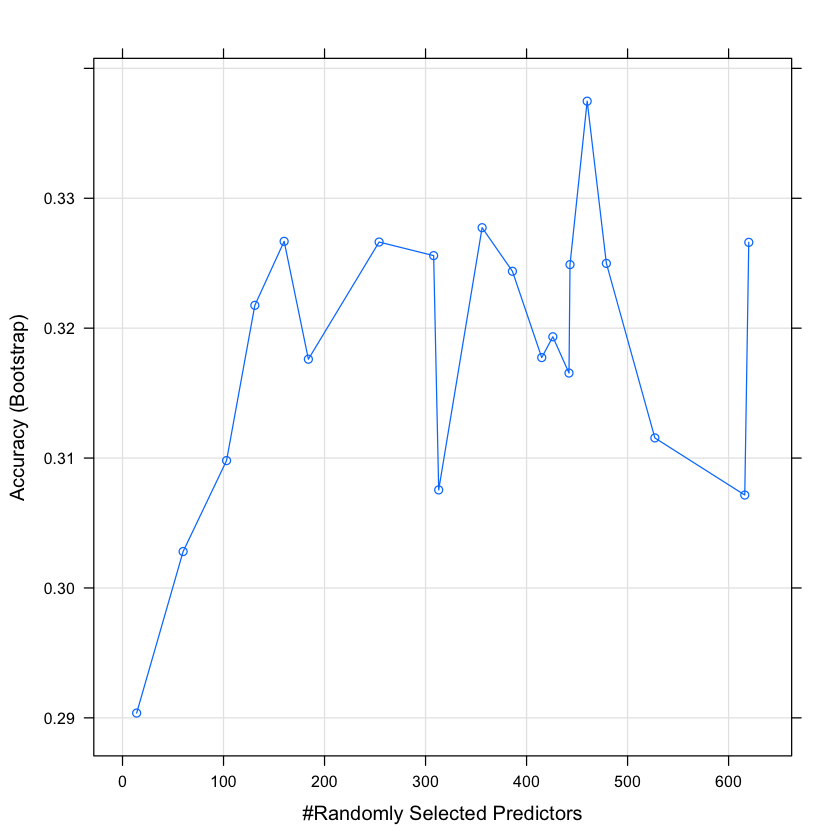

In [57]:
rsMetabolomicsrf
plot(rsMetabolomicsrf)

Ungrafted,X1103P,X3309C,SO4,MeanDecreaseAccuracy,MeanDecreaseGini


Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”

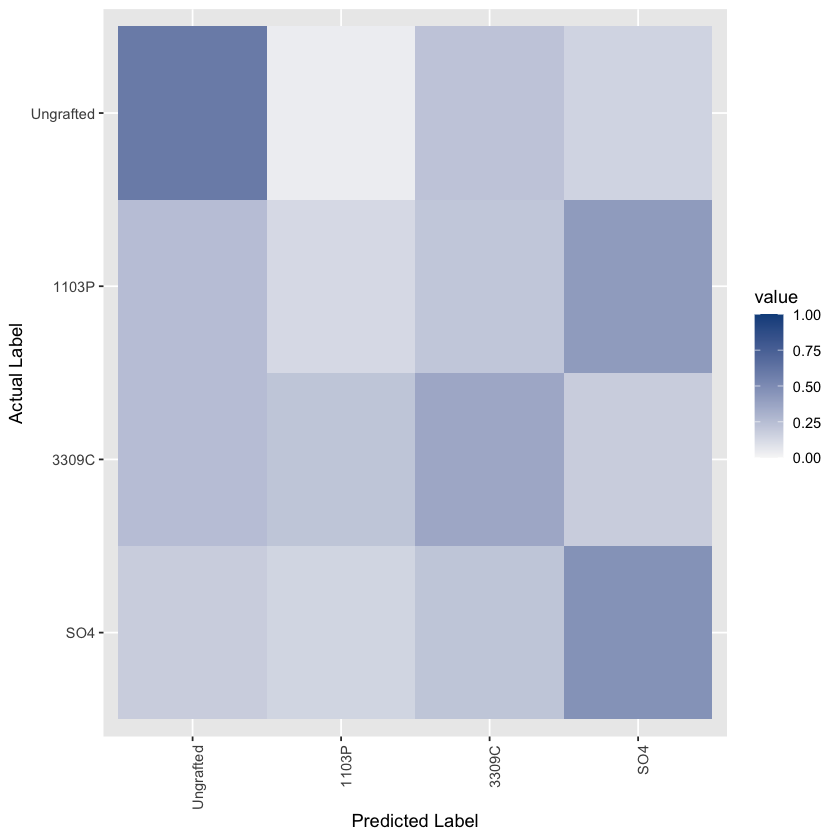

In [59]:
d <- rsMetabolomicsrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_Metabolomics_rootstockImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.03,]

d <- as.data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))
d <- d %>% gather(x, value, Ungrafted:SO4)
d$x <- factor(d$x, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))

p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_y_discrete(labels=rev(c('Ungrafted', '1103P', '3309C', 'SO4')))
p 

In [58]:
y_pred <- predict(rsMetabolomicsrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

           Reference
Prediction  Ungrafted 1103P 3309C SO4
  Ungrafted         5     1     3   0
  1103P             0     1     1   1
  3309C             0     2     3   3
  SO4               2     4     0   0

Overall Statistics
                                          
               Accuracy : 0.3462          
                 95% CI : (0.1721, 0.5567)
    No Information Rate : 0.3077          
    P-Value [Acc > NIR] : 0.40588         
                                          
                  Kappa : 0.1316          
                                          
 Mcnemar's Test P-Value : 0.08434         

Statistics by Class:

                     Class: Ungrafted Class: 1103P Class: 3309C Class: SO4
Sensitivity                    0.7143      0.12500       0.4286     0.0000
Specificity                    0.7895      0.88889       0.7368     0.7273
Pos Pred Value                 0.5556      0.33333       0.3750     0.0000
Neg Pred Value            

In [60]:
# fit Random Forest for phenology

# get train test labels
rs.labels <- meta$phenology
rs.labels <- factor(rs.labels, levels=c('Veraison', 'Harvest'))
y_train <- rs.labels[train_idx]
y_test <- rs.labels[test_idx]

pMetabolomicsGrid <- expand.grid(mtry=sample(x=2:length(colnames(data_sub)), size=20, replace=F))
pMetabolomicsrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=pMetabolomicsGrid, ntree=100, keep.forest=T, importance=1)

Random Forest 

107 samples
661 predictors
  2 classes: 'Veraison', 'Harvest' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 107, 107, 107, 107, 107, 107, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   60   0.9819370  0.9637254
   89   0.9820667  0.9640212
  145   0.9829272  0.9657567
  178   0.9819516  0.9638067
  183   0.9810128  0.9619231
  243   0.9830410  0.9660328
  294   0.9799403  0.9597137
  307   0.9791069  0.9580470
  332   0.9820898  0.9641139
  364   0.9790543  0.9579770
  382   0.9811352  0.9621379
  397   0.9801839  0.9602254
  404   0.9781313  0.9560782
  483   0.9760260  0.9519446
  491   0.9782222  0.9562201
  496   0.9780258  0.9558677
  511   0.9781557  0.9561298
  531   0.9791313  0.9580782
  586   0.9761031  0.9520182
  593   0.9781313  0.9560845

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 243.

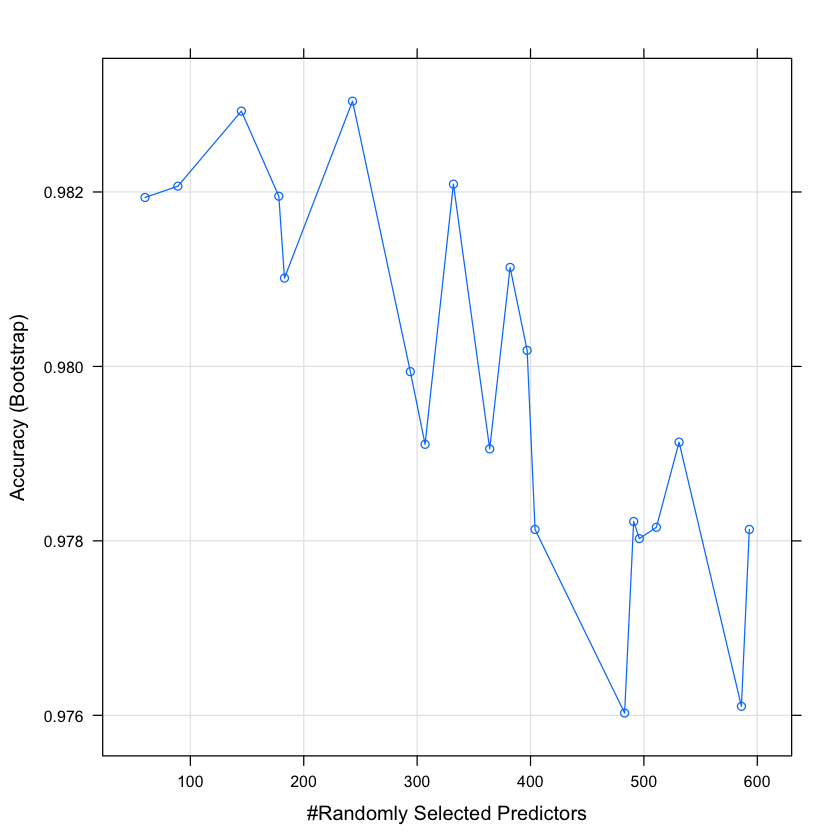

In [61]:
pMetabolomicsrf
plot(pMetabolomicsrf)

,Veraison,Harvest,MeanDecreaseAccuracy,MeanDecreaseGini
X18,0.04078724,0.05881020,0.05007247,6.700439
X47,0.09777719,0.08878973,0.09151499,11.063133
X71,0.03884102,0.02667370,0.03198249,4.195009
X122,0.04545435,0.04618654,0.04542939,5.293856


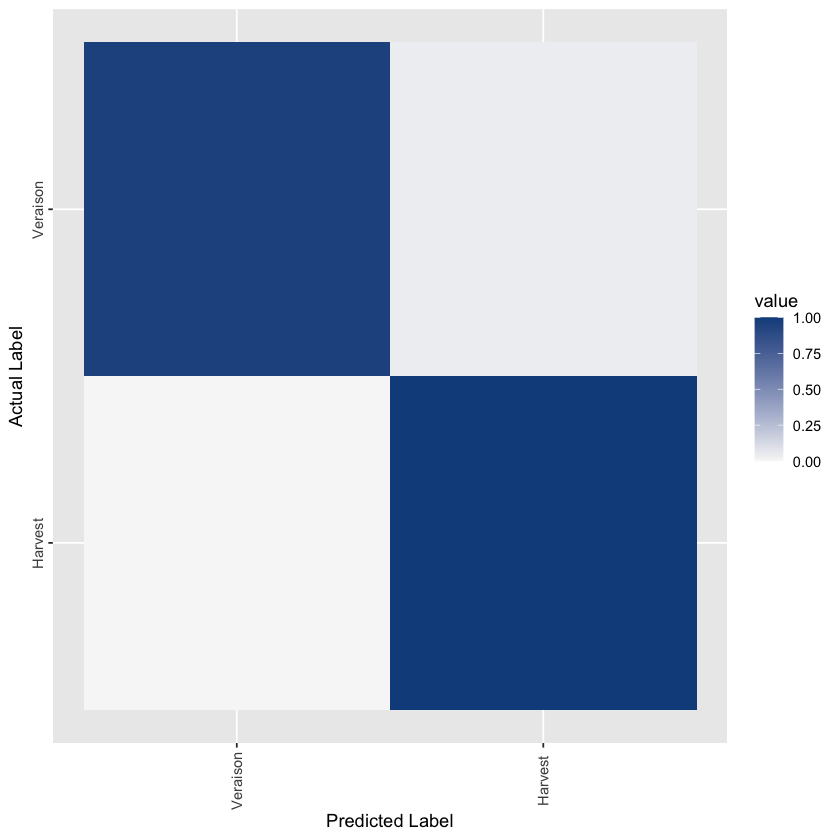

In [62]:
d <- pMetabolomicsrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_Metabolomics_phenologyImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.03,]

d <- as.data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('Veraison', 'Harvest'))
d <- d %>% gather(x, value, Veraison:Harvest)
d$x <- factor(d$x, levels=c('Veraison', 'Harvest'))

p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, vjust = 0.5), axis.text.y = element_text(angle = 90, hjust = 0.5)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_y_discrete(labels=rev(c('Veraison', 'Harvest')))
p 

In [63]:
y_pred <- predict(pMetabolomicsrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

          Reference
Prediction Veraison Harvest
  Veraison       14       0
  Harvest         0      12
                                     
               Accuracy : 1          
                 95% CI : (0.8677, 1)
    No Information Rate : 0.5385     
    P-Value [Acc > NIR] : 1.023e-07  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5385     
         Detection Rate : 0.5385     
   Detection Prevalence : 0.5385     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : Veraison   
                                     

In [64]:
# fit Random Forest for Rootstock X Phenology

# get train test labels
prs.labels <- as.factor(paste(meta$phenology, meta$rootstock, sep='_'))
prs.labels <- factor(prs.labels, levels=c('Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 'Veraison_Ungrafted',
                                          'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4', 'Harvest_Ungrafted'))
y_train <- prs.labels[train_idx]
y_test <- prs.labels[test_idx]


prsMetabolomicsGrid <- expand.grid(mtry=sample(x=2:length(colnames(data_sub)), size=20, replace=F))
prsMetabolomicsrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=prsMetabolomicsGrid, ntree=100, keep.forest=T, importance=1)

Random Forest 

107 samples
661 predictors
  8 classes: 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 'Veraison_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4', 'Harvest_Ungrafted' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 107, 107, 107, 107, 107, 107, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
    9   0.2534888  0.1573539
   21   0.2779333  0.1848732
   95   0.2998701  0.2085193
  146   0.3102687  0.2186454
  153   0.2925823  0.1994486
  165   0.3064267  0.2143756
  168   0.3088319  0.2172503
  201   0.3019899  0.2101617
  250   0.3089861  0.2181805
  256   0.3095481  0.2177321
  300   0.2908994  0.1977965
  306   0.3194497  0.2294172
  312   0.3108119  0.2200995
  321   0.3058070  0.2119559
  337   0.3088499  0.2169029
  411   0.3111342  0.2205393
  443   0.2989177  0.2065947
  503   0.3011460  0.2091188
  541   0.3096155  0.2183485
  589   0.2990242  0.2066393

Accuracy was used to select t

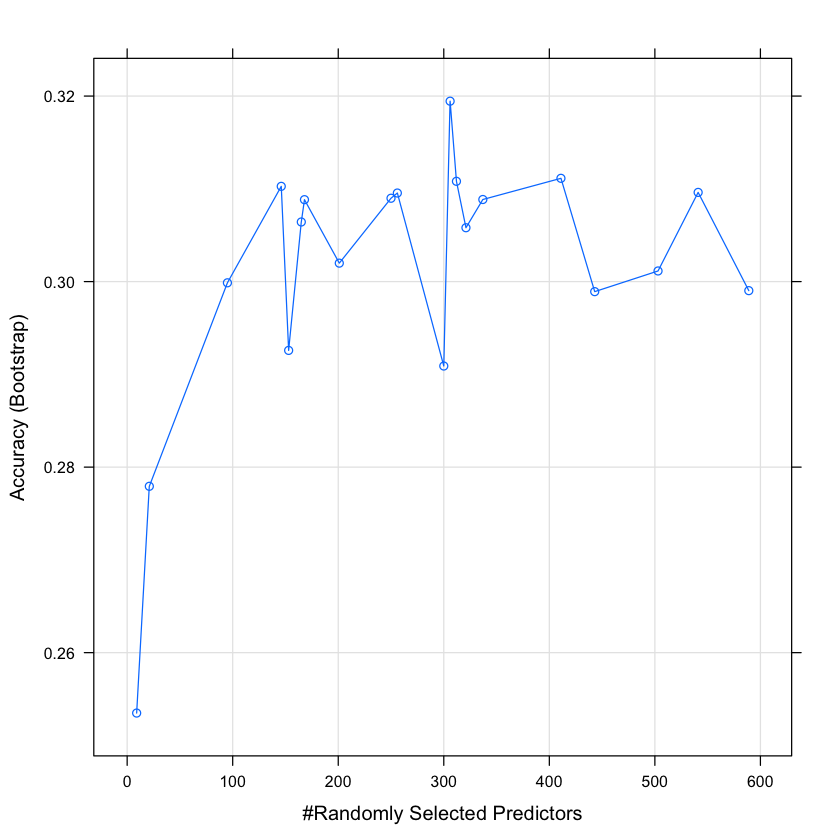

In [65]:
prsMetabolomicsrf
plot(prsMetabolomicsrf)

,Veraison_1103P,Veraison_3309C,Veraison_SO4,Veraison_Ungrafted,Harvest_1103P,Harvest_3309C,Harvest_SO4,Harvest_Ungrafted,MeanDecreaseAccuracy,MeanDecreaseGini
X47,0.05183333,0.02063095,0.02752381,0.03575397,0.01266667,0.0240119,0.05058333,0.04379762,0.03050712,3.332932


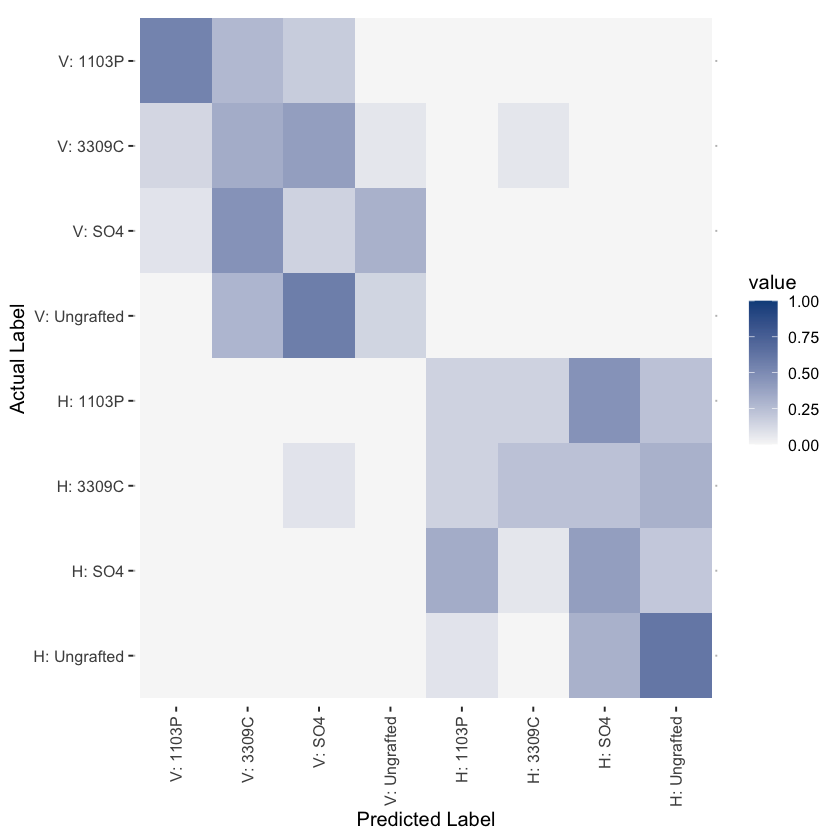

In [66]:
d <- prsMetabolomicsrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_metabolomics_rootstockPhenologyImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.03,]

d <- prsMetabolomicsrf$finalModel
d <- data.frame(d$confusion) %>% dplyr::select(Veraison_1103P:Harvest_Ungrafted)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 'Veraison_Ungrafted',
                            'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4', 'Harvest_Ungrafted'))
d <- d %>% gather(x, value, Veraison_1103P:Harvest_Ungrafted)
d$x <- factor(d$x, levels=c('Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 'Veraison_Ungrafted',
                            'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4', 'Harvest_Ungrafted'))


p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     ggpubr::theme_pubclean() + 
     theme(legend.position='right') + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) + 
     scale_x_discrete(labels=c("V: 1103P", "V: 3309C", "V: SO4", "V: Ungrafted",
                               "H: 1103P", "H: 3309C", "H: SO4", "H: Ungrafted")) + 
     scale_y_discrete(labels=rev(c("V: 1103P", "V: 3309C", "V: SO4", "V: Ungrafted",
                                   "H: 1103P", "H: 3309C", "H: SO4", "H: Ungrafted")))

p

In [67]:
y_pred <- predict(prsMetabolomicsrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

                    Reference
Prediction           Veraison_1103P Veraison_3309C Veraison_SO4
  Veraison_1103P                  1              0            1
  Veraison_3309C                  1              1            2
  Veraison_SO4                    3              1            0
  Veraison_Ungrafted              0              2            0
  Harvest_1103P                   0              0            0
  Harvest_3309C                   0              0            0
  Harvest_SO4                     0              0            0
  Harvest_Ungrafted               0              0            0
                    Reference
Prediction           Veraison_Ungrafted Harvest_1103P Harvest_3309C Harvest_SO4
  Veraison_1103P                      1             0             0           0
  Veraison_3309C                      0             0             0           0
  Veraison_SO4                        0             0             0           0
  Veraison_